# Analysis on base station discretization

Due to the low no. of concurrent users, this notebook explore the use of clustering to merge nearby basestations to increase to no. of concurrent users.

## requirements

- Shanghai Telecom dataset csv located at `{ROOT}/data/shanghai`

## import

In [2]:
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import folium
import numpy as np
import math
import datetime

## get distinct base stations

In [3]:
from src.data_preprocess.shanghai import read_csv
from src.path import default_shanghai_dataset_path

locs = pd.DataFrame()

for fname in tqdm.tqdm(os.listdir(default_shanghai_dataset_path())):
    df = read_csv(f'{default_shanghai_dataset_path()}/{fname}')

    # distinct locs
    df = df[['latitude', 'longitude']].drop_duplicates()

    locs = pd.concat([locs, df], ignore_index=True)
    locs = locs.drop_duplicates()

locs = locs[
    (locs['longitude'] >= 120.9) & 
    (locs['longitude'] <= 121.9) &
    (locs['latitude'] >= 30.69) &
    (locs['latitude'] <= 31.51)
]

locs

100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


latitude   longitude
0     31.200224  121.316463
1     31.159304  121.358718
2     31.230395  121.465990
3     30.975316  121.349759
4     31.009530  121.052076
...         ...         ...
3037  31.247703  121.536476
3038  31.200779  121.533917
3039  31.188183  121.440258
3040  31.196975  121.440602
3041  31.233410  121.483804

[2999 rows x 2 columns]

## clustering

Compute clusters using Gaussian Mixture model.

In [4]:
x = np.array([locs['latitude'], locs['longitude']])
x = x.transpose()
x

array([[ 31.200224, 121.316463],
       [ 31.159304, 121.358718],
       [ 31.230395, 121.46599 ],
       ...,
       [ 31.188183, 121.440258],
       [ 31.196975, 121.440602],
       [ 31.23341 , 121.483804]])

In [5]:
print(x.max(axis=0))
print(x.min(axis=0))
print((x.max(axis=0) + x.min(axis=0)) / 2)

[ 31.50595 121.87486]
[ 30.705762 120.901878]
[ 31.105856 121.388369]


In [6]:
from sklearn.mixture import GaussianMixture

n_clusters = 100

m = GaussianMixture(n_components=n_clusters, covariance_type='spherical')
m.fit(x)

GaussianMixture(covariance_type='spherical', n_components=100)

save clusters

In [7]:
np.save(f'mog_{n_clusters}.npy', m.means_)

plot clusters

In [8]:
# plot shanghai
from src.plot import get_shanghai_map
map = get_shanghai_map()

def haversine(lat1, lon1, lat2, lon2): #generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d * 1000 # meters

if True:
    for i in range(x.shape[0]):
        folium.CircleMarker(
            location=x[i, :],
            radius=1,
            weight=2,
            color='black'
        ).add_to(map)

for i in range(m.means_.shape[0]):
    folium.Circle(
        location=m.means_[i, :], 
        radius=haversine(31.11, m.means_[i, 1], 31.11, m.means_[i, 1] + 2 * math.sqrt(m.covariances_[i])),
        fill_color='cornflowerblue',
        color='blue',
        fill=True,
        weight=1,
        fill_opacity=0.6
    ).add_to(map)

map

## distribution of concurrent users

In [7]:
from src.data_preprocess.shanghai import read_csv, PreprocessConfig

df = read_csv(f'{default_shanghai_dataset_path()}/data_6.1~6.15.csv')
df = df.dropna()

df = df[
    (120.9 <= df['longitude']) & (df['longitude'] <= 121.9) &
    (30.69 <= df['latitude']) & (df['latitude'] <= 31.51)
]

config = PreprocessConfig(
    30,
    datetime.datetime(2014, 6, 2),
    7,
    True,
    keep_trajectory=lambda t: len(set(t.points)) >= 3
)

Nearest neighbor discretization.

Distribution is similar to Mahalanobis distance (m.predict), but sub-linear query time due to nearest neighbor index.

In [8]:
from src.data_preprocess.point import NearestNeighborDiscretizer, GridDiscretizer

#df[['latitude', 'longitude']] = m.means_[m.predict(df[['latitude', 'longitude']].to_numpy())]

discretizer = NearestNeighborDiscretizer(points=m.means_)
#discretizer = NearestNeighborDiscretizer(points=np.load('mog_50.npy'))

#discretizer = GridDiscretizer(xrange=(30.705762, 31.50595), yrange=(120.901878, 121.87486), dim=(8, 8))

df[['latitude', 'longitude']] = discretizer.discretize(df[['latitude', 'longitude']].to_numpy())

In [9]:
from src.data_preprocess.shanghai import preprocess

trajectories = preprocess(df, config)

aggregate_records: 100%|██████████| 336/336 [00:00<00:00, 634.63it/s]


No. of unique users

In [10]:
from src.utils import set_union, set_intersect
len(set_union(*[t.keys() for t in trajectories]))

3288

No. of persistent users

In [11]:
users = [*set_intersect(*[t.keys() for t in trajectories])]
len(users)

362

Visualize trajectory

In [140]:
from src.plot import plot_trajectory, get_shanghai_map
import random
import folium

uid = random.choice(users)
map = get_shanghai_map()

for _, row in locs.iterrows():
    folium.CircleMarker(location=(row['latitude'], row['longitude']), radius=1, weight=2, color='black').add_to(map)

for i in range(m.means_.shape[0]):
    folium.Circle(
        location=m.means_[i, :], 
        radius=haversine(31.11, m.means_[i, 1], 31.11, m.means_[i, 1] + 2 * math.sqrt(m.covariances_[i])),
        fill_color='cornflowerblue',
        color='blue',
        fill=True,
        weight=1,
        fill_opacity=0.6
    ).add_to(map)

plot_trajectory(trajectories[0][uid], color='red', map=map, marker=False)
plot_trajectory(trajectories[1][uid], color='blue', map=map, marker=False)
plot_trajectory(trajectories[2][uid], color='green', map=map, marker=False)



map

Count concurrent users

In [12]:
cnt = dict()

for bucket in tqdm.tqdm(trajectories):
    for i in range(48):
        mset = dict()

        for t in bucket.values():
            p = t.points[i]
            mset[p] = mset.get(p, 0) + 1

            for v in mset.values():
                cnt[v] = cnt.get(v, 0) + 1

100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


plot distribution of concurrent users

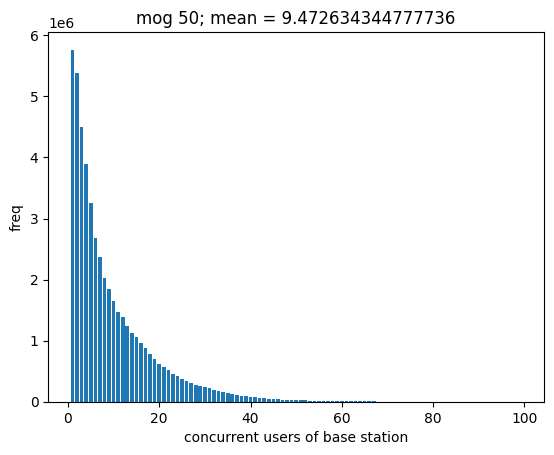

In [13]:
def plot_concurrent():
    n = sum(cnt.values())
    avg = np.dot(np.array([*cnt.keys()]), np.array([*cnt.values()]) / n)


    plt.bar(cnt.keys(), cnt.values())
    plt.title(f'mog 50; mean = {avg}')
    plt.xlabel('concurrent users of base station')
    plt.ylabel('freq')

plot_concurrent()


In [14]:
def haversine(lat1, lon1, lat2, lon2): #generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * math.pi / 180) * np.cos(lat2 * math.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan(np.sqrt(a) / np.sqrt(1-a))
    d = R * c
    return d * 1000 # meters

vel = []

for bucket in tqdm.tqdm(trajectories):
    for t in bucket.values():
        v = haversine(
            np.array(t.points)[1:, 0],
            np.array(t.points)[1:, 1],
            np.array(t.points)[:-1, 0],
            np.array(t.points)[:-1, 1]
        ) / 1000 / (config.delta_min / 60)

        vel += list(v)

100%|██████████| 7/7 [00:00<00:00, 11.18it/s]


plot distribution of speed

Text(0, 0.5, 'freq')

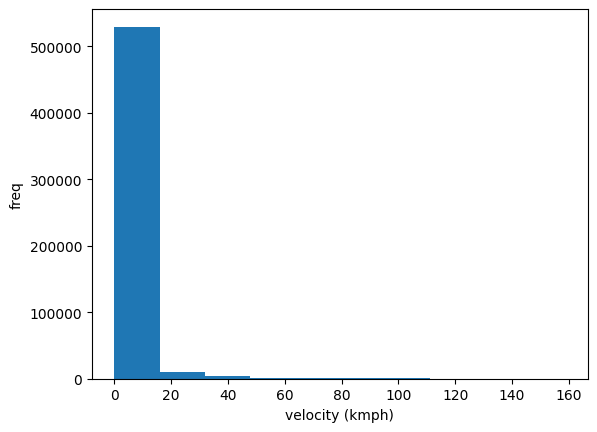

In [15]:
plt.hist([v for v in vel])
plt.xlabel('velocity (kmph)')
plt.ylabel('freq')

plot uniqueness

Text(0, 0.5, 'uniqueness')

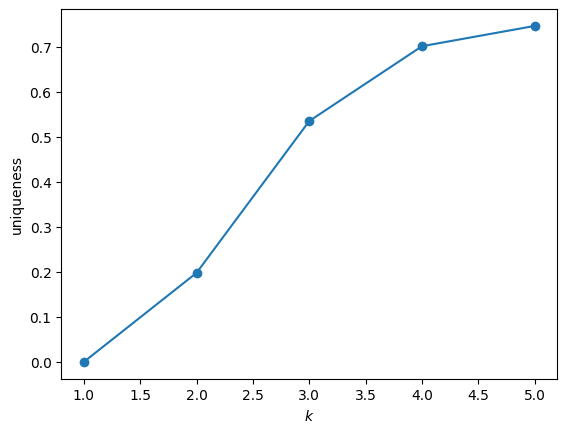

In [20]:
from src.eval.metrics import uniqueness

ks = [1, 2, 3, 4, 5]
unq = [uniqueness(trajectories, k, 'all') for k in ks]

plt.plot(ks, unq, marker='o')

plt.xlabel('$k$')
plt.ylabel('uniqueness')

## experiment on entire dataset

In [109]:
def f_key(s: str):
    s = s.split('~')[0]
    return float(s[5:])

def extract_drange(s: str):
    s = s[:s.rindex('.')] # remove extension
    s = s[5:] # remove prefix
    
    sd, ed = s.split('~')
    return (
        datetime.datetime(2014, int(sd.split('.')[0]), int(sd.split('.')[1])), 
        datetime.datetime(2014, int(ed.split('.')[0]), int(ed.split('.')[1]))
    )

fnames = sorted(os.listdir('../data/shanghai/'), key=f_key)

cnt = dict()
vel = []

for i in range(len(fnames)):
    df = read_csv(f'../data/shanghai/{fnames[i]}')

    min_date, max_date = extract_drange(fnames[i])
    n_day = max_date.day - min_date.day + 1

    if i + 1 < len(fnames):
        df2 = read_csv(f'../data/shanghai/{fnames[i + 1]}')
        df2 = df2[df2['start time'] < min_date + datetime.timedelta(days=n_day)]
        df = pd.concat([df, df2])
    else:
        n_day -= 1

    df = df.dropna()

    df = df[
        (120.9 <= df['longitude']) & (df['longitude'] <= 121.9) &
        (30.69 <= df['latitude']) & (df['latitude'] <= 31.51)
    ]

    df = df[
        (df['end time'] >= min_date) &
        (df['start time'] < min_date + datetime.timedelta(days=n_day))
    ]

    df[['latitude', 'longitude']] = discretizer.discretize(df[['latitude', 'longitude']].to_numpy())

    trajectories = preprocess(df, PreprocessConfig(delta_min=30, output_dir='.', start_date=min_date, n_day=n_day, verbose=True))

    for bucket in tqdm.tqdm(trajectories):
        for t in bucket.values():
            v = haversine(
                np.array(t.points)[1:, 0],
                np.array(t.points)[1:, 1],
                np.array(t.points)[:-1, 0],
                np.array(t.points)[:-1, 1]
            ) / 1000 / (config.delta_min / 60)

            vel += list(v)

    '''
    for bucket in tqdm.tqdm(trajectories):
        for j in range(48):
            mset = dict()

            for t in bucket.values():
                p = t.points[j]
                mset[p] = mset.get(p, 0) + 1

                for v in mset.values():
                    cnt[v] = cnt.get(v, 0) + 1
    '''

    print(f'{i + 1} done')

100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


1 done


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


2 done


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


3 done


100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


4 done


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


5 done


100%|██████████| 16/16 [00:02<00:00,  5.58it/s]


6 done


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


7 done


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


8 done


100%|██████████| 15/15 [00:02<00:00,  6.62it/s]


9 done


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


10 done


100%|██████████| 15/15 [00:02<00:00,  5.82it/s]


11 done


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

12 done


distribution of velocity of entire dataset (after ffill interpolation)

(array([4.11416e+05, 2.22236e+05, 6.77380e+04, 2.98320e+04, 1.45470e+04,
        7.46600e+03, 7.61000e+03, 5.22700e+03, 1.46300e+03, 7.00000e+00]),
 array([  4.82791367,  21.08080014,  37.33368662,  53.5865731 ,
         69.83945958,  86.09234606, 102.34523254, 118.59811902,
        134.85100549, 151.10389197, 167.35677845]),
 <BarContainer object of 10 artists>)

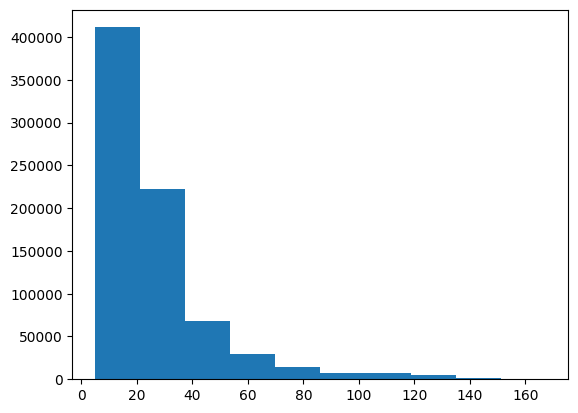

In [111]:
plt.hist([v for v in vel if v > 0])

distribution of concurrent users

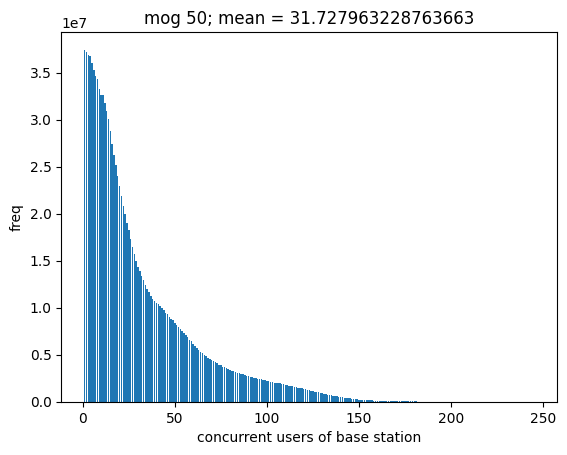

In [191]:
plot_concurrent()

## Results using different discretization method

### raw (no aggregation)

![raw](sh_raw.png)

### Grid discretization

![8x8 grid](sh_grid_8_8.png)
![10x10 grid](sh_grid_10_10.png)
![20x20 grid](sh_grid_20_20.png)

### clustering

![50 clusters](sh_mog_50.png)
![50 clusters](sh_mog_64.png)
![50 clusters](sh_mog_100.png)
![50 clusters](sh_mog_400.png)

## Analysis on effects of no. of cluster on no. of concurrent users and no. of persistent users 

In [ ]:
from src.data_preprocess.shanghai import read_csv, PreprocessConfig
from src.data_preprocess.point import NearestNeighborDiscretizer
from src.data_preprocess.shanghai import preprocess
from sklearn.mixture import GaussianMixture
from src.utils import set_intersect


raw_df = read_csv('../data/shanghai/data_6.1~6.15.csv')
raw_df = raw_df.dropna()

raw_df = raw_df[
    (120.9 <= raw_df['longitude']) & (raw_df['longitude'] <= 121.9) &
    (30.69 <= raw_df['latitude']) & (raw_df['latitude'] <= 31.51)
]

config = PreprocessConfig(
    30,
    datetime.datetime(2014, 6, 2),
    14,
    True,
    keep_trajectory=lambda t: len(set(p for p in t.points if p != None)) >= 3
)

unique_users = []
concurrent_users = []
cluster_counts = [50, 75, 100, 125]

for k in cluster_counts:
    df = raw_df.copy()

    m = GaussianMixture(n_components=k, covariance_type='spherical')
    m.fit(x)

    discretizer = NearestNeighborDiscretizer(points=m.means_)
    df[['latitude', 'longitude']] = discretizer.discretize(df[['latitude', 'longitude']].to_numpy())

    trajectories = preprocess(df, config)

    unique_users.append(
        len([*set_intersect(*[t.keys() for t in trajectories])])
    )

    cnt = dict()

    for bucket in tqdm.tqdm(trajectories):
        for i in range(48):
            mset = dict()

            for t in bucket.values():
                p = t.points[i]
                mset[p] = mset.get(p, 0) + 1

                for v in mset.values():
                    cnt[v] = cnt.get(v, 0) + 1
    
    n = sum(cnt.values())
    avg = np.dot(np.array([*cnt.keys()]), np.array([*cnt.values()]) / n)
    concurrent_users.append(avg)

plt.plot(cluster_counts, unique_users, label='no. persistent users')
plt.plot(cluster_counts, concurrent_users, label='avg no. concurrent users')
plt.legend()
plt.ylabel('frequency')
plt.xlabel('no. clusters')